In [458]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset
from torch.optim import SGD

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from scipy.stats import beta

In [459]:
INPUT_SIZE = 784
NUM_LAYERS = 2
NUM_HIDDEN_UNITS = 64
OUTPUT_SIZE = 10

NUM_EPOCHS = 10
BATCH_SIZE = 250
LEARNING_RATE = 0.1
MOMENTUM = 0.9

NUM_UNDERLYING_DISTRIBUTION = 30000

In [460]:
DATASET = torchvision.datasets.MNIST(root='../data', train=True, transform=transforms.ToTensor(), download=True)

INDEX_UNDERLYING=list(range(NUM_UNDERLYING_DISTRIBUTION))
SUBSET_UNDERLYING=Subset(DATASET, INDEX_UNDERLYING)
LOADER_UNDERLYING=DataLoader(dataset=SUBSET_UNDERLYING, batch_size=BATCH_SIZE, shuffle=False)

In [461]:
class NeuralNet(nn.Module):
    def __init__(self, input_size, num_layers, hidden_size, output_size):
        super(NeuralNet, self).__init__()
        self.hidden = nn.ModuleList()
        self.input_layer = nn.Linear(input_size, hidden_size)
        for k in range(num_layers-1):
            self.hidden.append(nn.Linear(hidden_size, hidden_size))
        self.output_layer = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        x=self.input_layer(x)
        x=x.relu()
        for layer in self.hidden:
            x=layer(x)
            x=x.relu()
        x=self.output_layer(x)
        return x
    
def ReLU_glorot_init(model):
    for name, param in model.named_parameters():
        
        if name.endswith(".bias"):
            param.data.fill_(0)
        else:
            nn.init.xavier_normal_(param)

In [462]:
def get_bound(num_samples, eta, zeta, gamma, alpha, delta):
    index_sample, index_approx=train_test_split(np.random.choice(INDEX_UNDERLYING, num_samples, replace=False), test_size=eta)
    index_empirical_error, index_train=train_test_split(index_sample, test_size=zeta)

    num_approx=len(index_approx)
    num_empirical_error=len(index_empirical_error)
    num_train=len(index_train)
    
    subset_train=Subset(SUBSET_UNDERLYING, index_train)
    subset_empirical_error=Subset(SUBSET_UNDERLYING, index_empirical_error)

    loader_train = DataLoader(dataset=subset_train, batch_size=BATCH_SIZE, shuffle=True)
    loader_empirical_error = DataLoader(dataset=subset_empirical_error, batch_size=BATCH_SIZE, shuffle=True)

    model = NeuralNet(INPUT_SIZE, NUM_LAYERS, NUM_HIDDEN_UNITS, OUTPUT_SIZE)
    ReLU_glorot_init(model)

    criterion = nn.CrossEntropyLoss()
    optimizer = SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)

    for epoch in range(NUM_EPOCHS):
        for images, labels in loader_train:
            images = images.reshape(-1, INPUT_SIZE)
            outputs = model(images)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        #print('Epoch {}: Loss {:.3f}'.format(epoch+1,loss.item()))

    empirical_accuracy=0
    with torch.no_grad():
        for image, label in loader_empirical_error:
            image = image.reshape(-1, INPUT_SIZE)
            output = model(image)
            predictions=output.max(1)[1]
            empirical_accuracy+=sum((predictions==label).tolist())
    empirical_accuracy/=num_empirical_error

    true_accuracy=0
    correct_bools=[]
    with torch.no_grad():
        for image, label in LOADER_UNDERLYING:
            image = image.reshape(-1, INPUT_SIZE)
            output = model(image)
            predictions=output.max(1)[1]
            correct_bools+=(predictions==label).tolist()
            true_accuracy+=sum((predictions==label).tolist())
    true_accuracy/=NUM_UNDERLYING_DISTRIBUTION

    index_verifiable=[]
    for k,correct in enumerate(correct_bools):
        if correct:
            index_verifiable.append(k)

    prop_to_sample=min(1,gamma/true_accuracy)
    Delta_prime, Delta=train_test_split(index_verifiable, test_size=prop_to_sample)

    p_Delta=len(Delta)/NUM_UNDERLYING_DISTRIBUTION
    p_hat=0
    for ind in index_approx:
        if ind in Delta:
            p_hat+=1
    p_hat/=num_approx
    p_L=beta.ppf(alpha,int(num_approx*p_hat),int(num_approx-num_approx*p_hat+1))

    log_component = np.log((1-p_L+np.sqrt((1-p_L)**2+4*delta**(1/num_empirical_error)*p_L))/(2*delta**(1/num_empirical_error)))
    bound=(1-train_accuracy)+np.sqrt(log_component/2)

    return 1-true_accuracy, 1-empirical_accuracy, bound, 1-(delta+alpha*(1-delta)), num_approx, num_empirical_error, num_train

In [475]:
ZETA=0.5
GAMMA=0.5
ALPHA=0.025
DELTA=0.025

SAMPLE_SIZES=[500,750,1000,1500]
ETAS=np.linspace(0.1,0.9,9)

true_errors=[[] for n in range(len(SAMPLE_SIZES))]
empirical_errors=[[] for n in range(len(SAMPLE_SIZES))]
bounds=[[] for n in range(len(SAMPLE_SIZES))]
n_as=[[] for n in range(len(SAMPLE_SIZES))]
n_es=[[] for n in range(len(SAMPLE_SIZES))]
n_ts=[[] for n in range(len(SAMPLE_SIZES))]

for k,sample_size in enumerate(SAMPLE_SIZES):
    for eta in ETAS:
        true_error, empirical_error, bound, con, n_a, n_e, n_t = get_bound(sample_size,eta,ZETA,GAMMA,ALPHA,DELTA)
        true_errors[k].append(true_error)
        empirical_errors[k].append(empirical_error)
        bounds[k].append(bound)
        n_as[k].append(n_a)
        n_es[k].append(n_e)
        n_ts[k].append(n_t)
        print('Sample Size {} eta {}'.format(sample_size,eta))

Sample Size 500 eta 0.1
Sample Size 500 eta 0.2
Sample Size 500 eta 0.30000000000000004
Sample Size 500 eta 0.4
Sample Size 500 eta 0.5
Sample Size 500 eta 0.6
Sample Size 500 eta 0.7000000000000001
Sample Size 500 eta 0.8
Sample Size 500 eta 0.9
Sample Size 750 eta 0.1
Sample Size 750 eta 0.2
Sample Size 750 eta 0.30000000000000004
Sample Size 750 eta 0.4
Sample Size 750 eta 0.5
Sample Size 750 eta 0.6
Sample Size 750 eta 0.7000000000000001
Sample Size 750 eta 0.8
Sample Size 750 eta 0.9
Sample Size 1000 eta 0.1
Sample Size 1000 eta 0.2
Sample Size 1000 eta 0.30000000000000004
Sample Size 1000 eta 0.4
Sample Size 1000 eta 0.5


IndexError: list index out of range

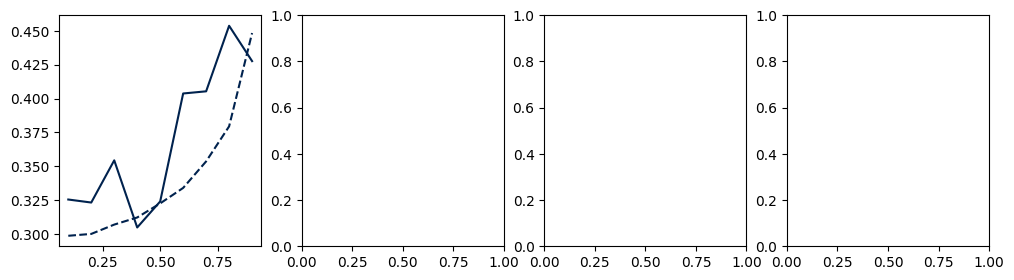

In [473]:
fig, axs = plt.subplots(1,4,figsize=(12,3))
colors = plt.cm.cividis(np.linspace(0, 1, len(sample_sizes)))
for i, ax in enumerate(axs):
    ax.plot(props_to_approx, true_errors[i], color=colors[0], label='True Error')
    ax.plot(props_to_approx, bounds[i], color=colors[0], label='Bound', linestyle='dashed')
    #col.plot(props_to_approx, empirical_errors[i*2+j], color=colors[0], label='Empirical Error', linestyle='dotted')
    ax.set_title('Train {}, Err {}, App {}'.format(n_ts[i][0], n_es[i][0],n_as[i][0]))
    ax.legend()